Iñigo Martin Melero

## Participante 27

Hacemos a lo que se refieren algunos papers. Nuestros datos de entrada son:

- Fisiológico: 2500000 elementos, medido milisegundo a milisegundo. 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10...
- Joystick: 40000 elementos, medido de 50 milisegundos en 50 milisegundos. 0, 50, 100, 150...

Cambiaremos los dataset de entrada para partir en igualdad de condiciones a los papers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
from scipy import pi
from scipy.fftpack import rfft, rfftfreq

Leemos el csv del Joystick, y lo representamos.

In [2]:
df1=pd.read_csv('Bruto/sub_27_annotations.csv')
df1=df1.rename(columns={"jstime": "time"})
print(df1)

          time  valence  arousal  video
0            0      5.0    5.000     10
1           50      5.0    5.000     10
2          100      5.0    5.000     10
3          150      5.0    5.000     10
4          200      5.0    5.000     10
...        ...      ...      ...    ...
49027  2451350      5.0    5.027     12
49028  2451400      5.0    5.027     12
49029  2451450      5.0    5.027     12
49030  2451500      5.0    5.027     12
49031  2451550      5.0    5.027     12

[49032 rows x 4 columns]


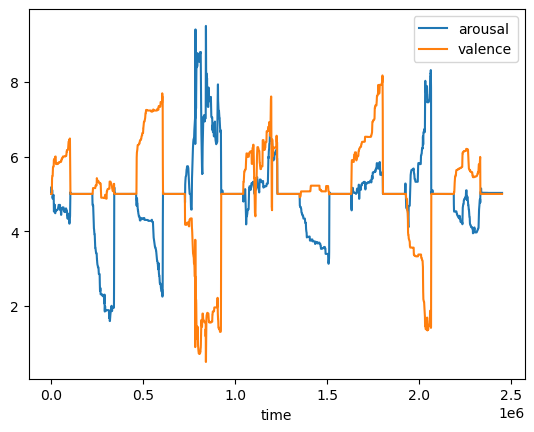

In [3]:
df1.plot(x="time", y=["arousal","valence"])
plt.show()

Leemos el csv de las variables Fisiológicas, y las representamos.

In [4]:
df2=pd.read_csv('Bruto/sub_27_physiological.csv')
df2=df2.rename(columns={"daqtime": "time"})
length_orig_df2=len(df2)
print(df2)

            time    ecg     bvp     gsr     rsp     skt  emg_zygo  emg_coru  \
0              0  1.037  36.263  37.352  46.475  27.668     8.275     7.248   
1              1  1.046  36.370  37.376  46.485  27.678     8.233     7.207   
2              2  1.056  36.476  37.399  46.495  27.689     8.192     7.165   
3              3  1.066  36.583  37.423  46.504  27.700     8.151     7.124   
4              4  1.076  36.507  37.482  46.524  27.703     8.232     7.165   
...          ...    ...     ...     ...     ...     ...       ...       ...   
2451579  2451579  0.784  36.772  15.751  43.039  25.014     7.329     5.646   
2451580  2451580  0.780  36.883  15.704  43.058  25.011     7.289     5.605   
2451581  2451581  0.784  37.018  15.770  43.049  25.018     7.166     5.645   
2451582  2451582  0.761  37.144  15.806  43.049  25.021     7.165     5.645   
2451583  2451583  0.751  36.820  15.806  43.068  25.025     7.287     5.686   

         emg_trap  video  
0          16.446     10

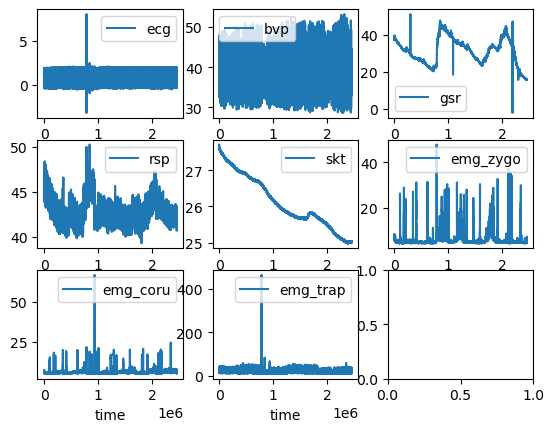

In [5]:
#define subplot layout
fig, axes = plt.subplots(nrows=3, ncols=3)

#add DataFrames to subplots
df2.plot(ax=axes[0,0],x="time",y="ecg")
df2.plot(ax=axes[0,1],x="time",y="bvp")
df2.plot(ax=axes[0,2],x="time",y="gsr")
df2.plot(ax=axes[1,0],x="time",y="rsp")
df2.plot(ax=axes[1,1],x="time",y="skt")
df2.plot(ax=axes[1,2],x="time",y="emg_zygo")
df2.plot(ax=axes[2,0],x="time",y="emg_coru")
df2.plot(ax=axes[2,1],x="time",y="emg_trap")
plt.show()

<AxesSubplot:xlabel='time'>

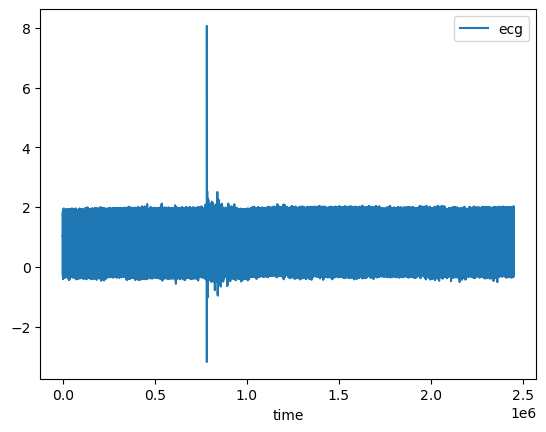

In [6]:
df2.plot(x="time",y="ecg")

<AxesSubplot:xlabel='time'>

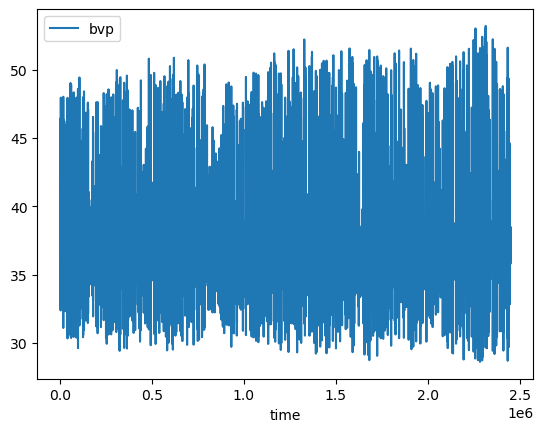

In [7]:
df2.plot(x="time",y="bvp")

<AxesSubplot:xlabel='time'>

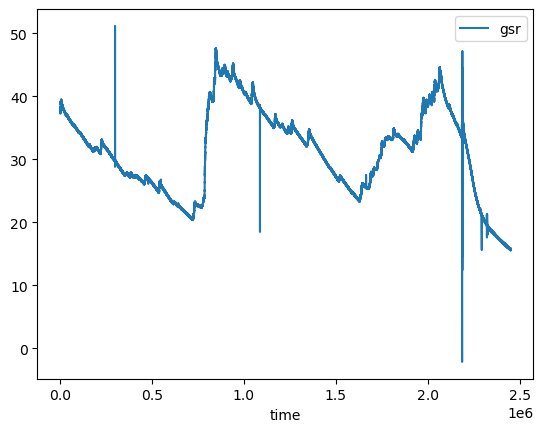

In [8]:
df2.plot(x="time",y="gsr")

<AxesSubplot:xlabel='time'>

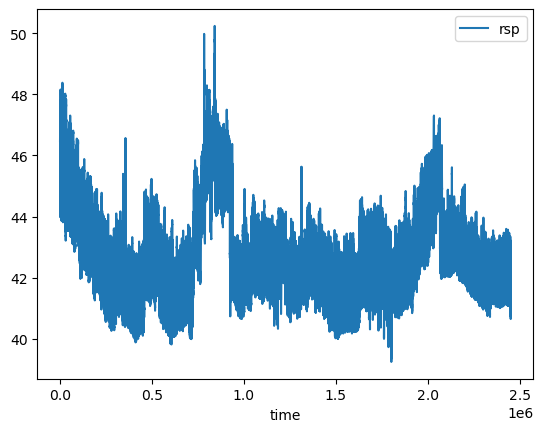

In [9]:
df2.plot(x="time",y="rsp")

<AxesSubplot:xlabel='time'>

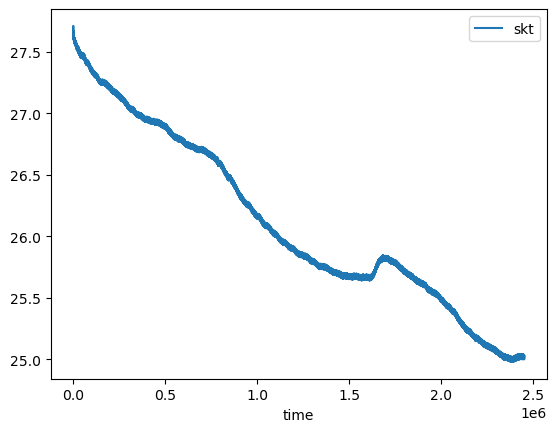

In [10]:
df2.plot(x="time",y="skt")


<AxesSubplot:xlabel='time'>

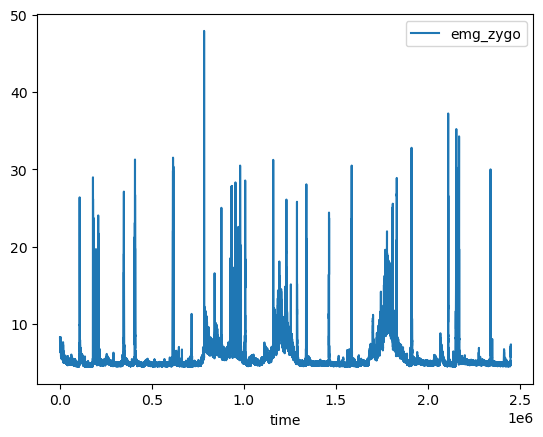

In [11]:
df2.plot(x="time",y="emg_zygo")


<AxesSubplot:xlabel='time'>

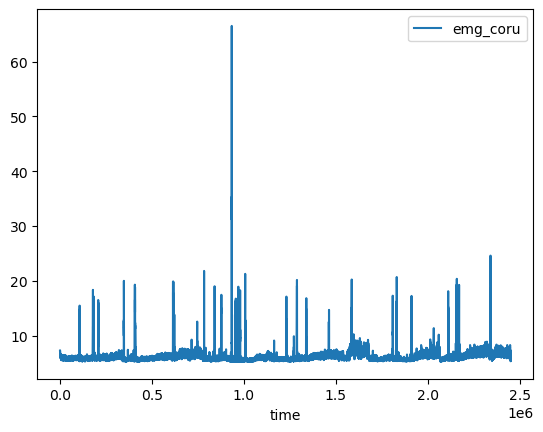

In [12]:
df2.plot(x="time",y="emg_coru")

<AxesSubplot:xlabel='time'>

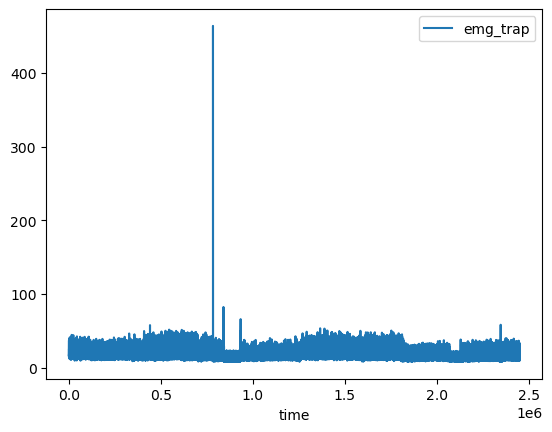

In [13]:
df2.plot(x="time",y="emg_trap")

El paper más completo que trata esto es CorrNet, donde se hace:

"Since the sampling rates of V-A and signals are 20 and 1000 Hz
respectively, we down-sampled all the signals to 50 Hz by decimation down-sampling. The EDA signals were
first filtered using a low pass filter with a 2 Hz cutoff frequency to remove noise.
For the BVP signal, we pre-processed it with a four-order butterworth bandpass filter with
cutoff frequencies [30, 200] Hz to eliminate the bursts. An elliptic band-pass filter
with cutoff frequencies [0.005, 0.1] was used to filter the ST signal. We followed the
standard filtering procedure widely used in previous works to pre-process the
physiological signals. Then the filtered signals are segmented into 2-second (sample size:
100 for CASE) instances."

O sea:

A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

D) Se normalizan las señales a 0 - 1, segun Min - Max.

E) Se busca la frecuencia en común de ambos a 50 Hz. Se hizo un estudio y fue la solución de compromiso.

F) Se utilizan ventanas de 2 segundos.

Lo vamos haciendo poco a poco.

    A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

<AxesSubplot:>

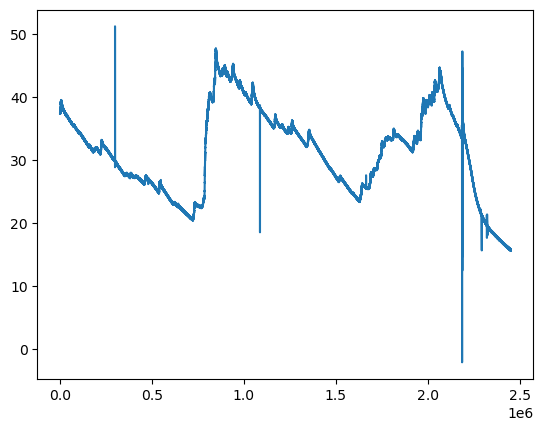

In [14]:
gsr_signal_notfiltered=df2['gsr']
gsr_signal_notfiltered.plot()

Representamos la senal en el dominio de la frecuencia. Vemos que hay frecuencias hasta el 500. Las querremos quitar todas menos las menores a 2 Hz. 

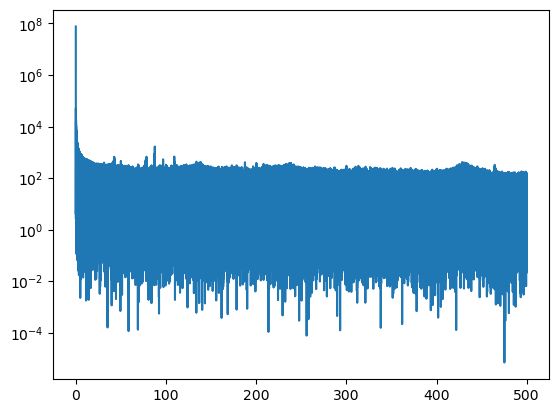

In [15]:
yf = rfft(gsr_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

In [16]:
lowpassfilter=signal.butter(N=10, Wn=2, btype='lp', fs=1000, output='sos')
gsr_filtered = signal.sosfilt(lowpassfilter, gsr_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias a partir de los 2 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente las frecuencias mayores a 2 Hz. 

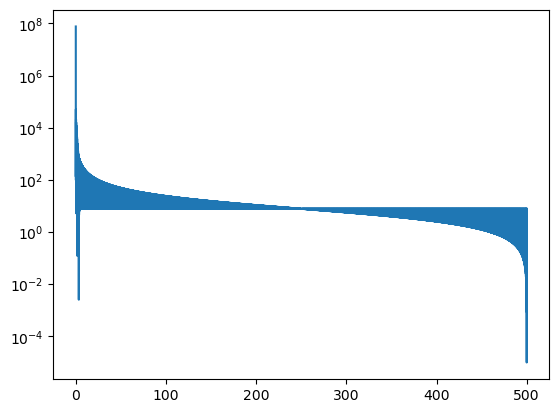

In [17]:
yf = rfft(gsr_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

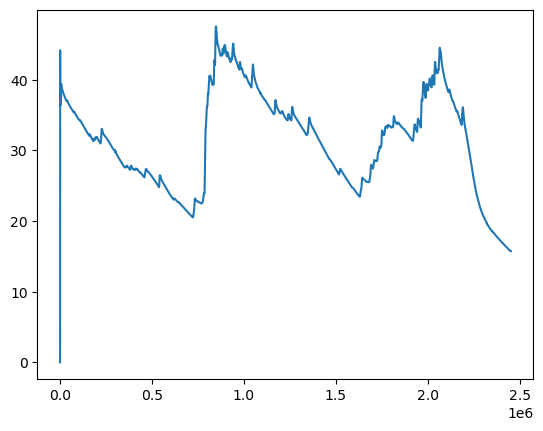

In [18]:
plt.plot(gsr_filtered)

In [19]:
gsr_signal_filtered = pd.DataFrame(gsr_filtered)
gsr_signal_filtered=gsr_signal_filtered.round(3)
gsr_signal_filtered=gsr_signal_filtered.rename(columns={0: "gsr"})
gsr_signal_filtered

gsr
0         0.000
1         0.000
2         0.000
3         0.000
4         0.000
...         ...
2451579  15.724
2451580  15.724
2451581  15.724
2451582  15.724
2451583  15.724

[2451584 rows x 1 columns]

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

<AxesSubplot:>

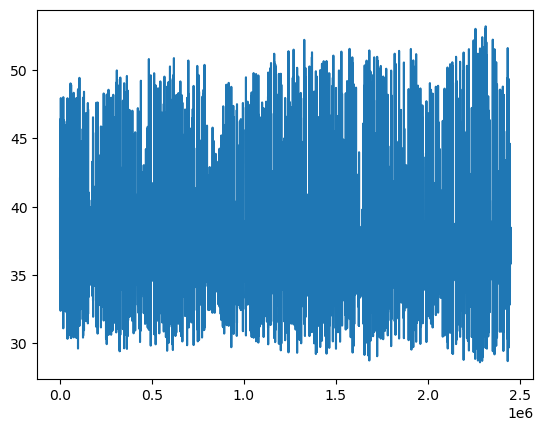

In [20]:
bvp_signal_notfiltered=df2['bvp']
bvp_signal_notfiltered.plot()

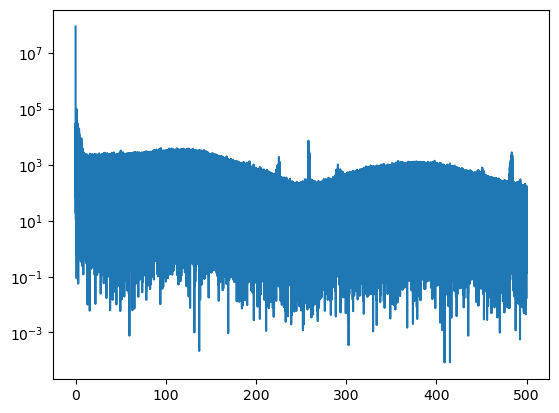

In [21]:
yf = rfft(bvp_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos el filtro Butter con frecuencias de corte de 30 a 200 Hz, de cuarto orden. Es un filtro paso banda.

In [22]:
butterfilter=signal.butter(N=4, Wn=[30,200], btype='bandpass', fs=1000, output='sos')
bvp_filtered = signal.sosfilt(butterfilter, bvp_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias menores de 30 Hz y mayores a 200 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente esas frecuencias.

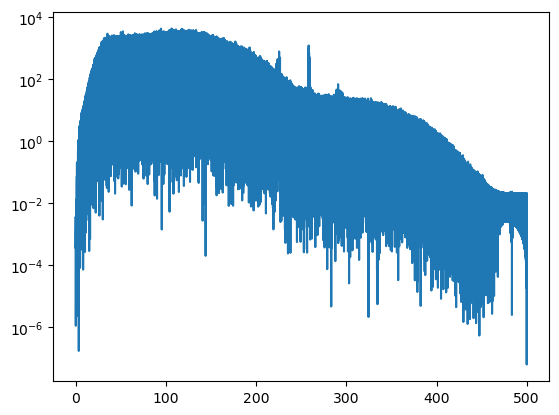

In [23]:
yf = rfft(bvp_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

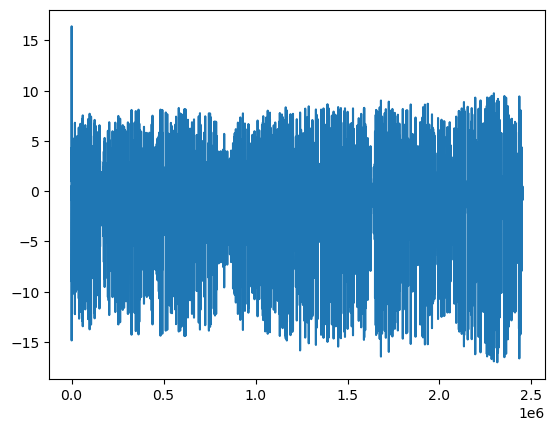

In [24]:
plt.plot(bvp_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [25]:
bvp_signal_filtered = pd.DataFrame(bvp_filtered)
bvp_signal_filtered=bvp_signal_filtered.round(3)
bvp_signal_filtered=bvp_signal_filtered.rename(columns={0: "bvp"})
bvp_signal_filtered=bvp_signal_filtered.add(37)
bvp_signal_filtered

bvp
0        38.008
1        42.624
2        50.245
3        53.411
4        46.248
...         ...
2451579  37.032
2451580  37.071
2451581  37.034
2451582  36.976
2451583  37.001

[2451584 rows x 1 columns]

    C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

<AxesSubplot:>

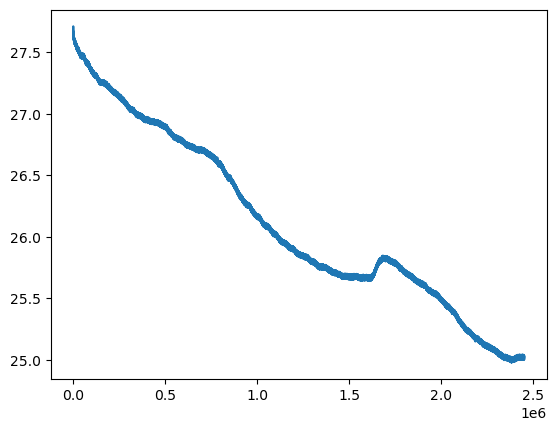

In [26]:
skt_signal_notfiltered=df2['skt']
skt_signal_notfiltered.plot()

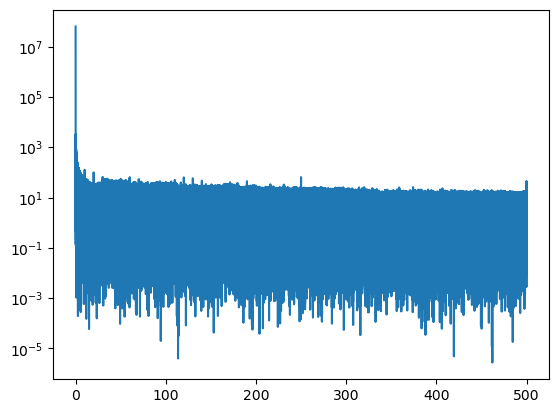

In [27]:
yf = rfft(skt_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos nuestro filtro eliptico con frecuencias corte [0.005, 0.1] a señal skt.

In [28]:
ellipticfilter=signal.ellip(N=4,rp=1, rs=1, Wn=[0.005,0.1], btype='bandpass', fs=1000, output='sos')
skt_filtered = signal.sosfilt(ellipticfilter, skt_signal_notfiltered)

Comprobamos la senal filtrada. Algo ha filtrado.

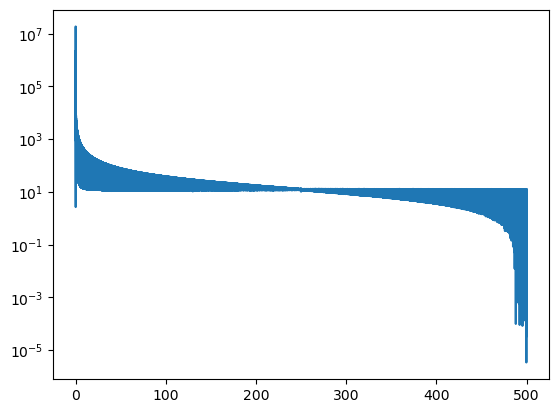

In [29]:
yf = rfft(skt_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

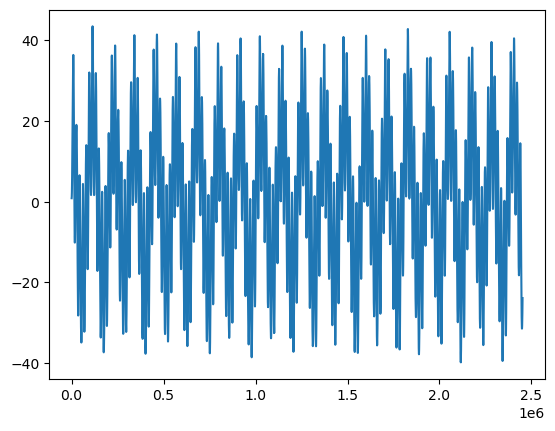

In [30]:
plt.plot(skt_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [31]:
skt_signal_filtered = pd.DataFrame(skt_filtered)
skt_signal_filtered=skt_signal_filtered.round(3)
skt_signal_filtered=skt_signal_filtered.rename(columns={0: "skt"})
skt_signal_filtered=skt_signal_filtered.add(40)
skt_signal_filtered

skt
0        40.887
1        40.887
2        40.887
3        40.888
4        40.888
...         ...
2451579  16.128
2451580  16.132
2451581  16.137
2451582  16.141
2451583  16.146

[2451584 rows x 1 columns]

D) Se normalizan las senales.

Antes de normalizarlas, vamos a borrar las primeras 5000, ya que por los filtrados los principios de las senales son un poco raros. Borramos las columnas que acabamos de tunear del dataframe con todo.

In [32]:
df2=df2.drop(columns=["skt","bvp","gsr"])
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video
0              0  1.037  46.475     8.275     7.248    16.446     10
1              1  1.046  46.485     8.233     7.207    16.446     10
2              2  1.056  46.495     8.192     7.165    16.446     10
3              3  1.066  46.504     8.151     7.124    16.446     10
4              4  1.076  46.524     8.232     7.165    16.406     10
...          ...    ...     ...       ...       ...       ...    ...
2451579  2451579  0.784  43.039     7.329     5.646    13.399     12
2451580  2451580  0.780  43.058     7.289     5.605    14.505     12
2451581  2451581  0.784  43.049     7.166     5.645    15.777     12
2451582  2451582  0.761  43.049     7.165     5.645    17.172     12
2451583  2451583  0.751  43.068     7.287     5.686    18.852     12

[2451584 rows x 7 columns]

In [33]:
df2=pd.concat([df2, bvp_signal_filtered, gsr_signal_filtered,skt_signal_filtered], axis=1)
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video     bvp  \
0              0  1.037  46.475     8.275     7.248    16.446     10  38.008   
1              1  1.046  46.485     8.233     7.207    16.446     10  42.624   
2              2  1.056  46.495     8.192     7.165    16.446     10  50.245   
3              3  1.066  46.504     8.151     7.124    16.446     10  53.411   
4              4  1.076  46.524     8.232     7.165    16.406     10  46.248   
...          ...    ...     ...       ...       ...       ...    ...     ...   
2451579  2451579  0.784  43.039     7.329     5.646    13.399     12  37.032   
2451580  2451580  0.780  43.058     7.289     5.605    14.505     12  37.071   
2451581  2451581  0.784  43.049     7.166     5.645    15.777     12  37.034   
2451582  2451582  0.761  43.049     7.165     5.645    17.172     12  36.976   
2451583  2451583  0.751  43.068     7.287     5.686    18.852     12  37.001   

            gsr     skt  
0         0.000  40.887  
1         0.000  40.887  
2         0.000  40.887  
3         0.000  40.888  
4         0.000  40.888  
...         ...     ...  
2451579  15.724  16.128  
2451580  15.724  16.132  
2451581  15.724  16.137  
2451582  15.724  16.141  
2451583  15.724  16.146  

[2451584 rows x 10 columns]

Tras aclarar esto, ya pasamos a normalizar. Antes, quitamos los videos que van al train, para que se normalicen solo los datos que van a ser entrenados realmente (sin los videos de BlueScreen, EndVid y StartVid).

In [34]:
df2 = df2[df2.video != 10]
df2 = df2[df2.video != 11]
df2 = df2[df2.video != 12]
scaler = MinMaxScaler()
scaler.fit(df2)
normalized = pd.DataFrame(scaler.transform(df2), index=df2.index, columns=df2.columns)
df2_normalized = pd.DataFrame(normalized, columns=df2.columns)
df2_normalized=df2_normalized.drop(columns=["video","time"])
numvideo_bien = df2["video"] 
tiempo_bien=df2["time"] 
df2_normalized=df2_normalized.join(numvideo_bien)
df2_normalized=df2_normalized.join(tiempo_bien)
df2=df2_normalized[["time","ecg","bvp","gsr","skt","rsp","emg_zygo","emg_coru","emg_trap","video"]]
df2

time       ecg       bvp       gsr       skt       rsp  emg_zygo  \
221501    221501  0.350489  0.632104  0.422327  0.784214  0.197983  0.010344   
221502    221502  0.349689  0.631656  0.422327  0.784139  0.201598  0.009446   
221503    221503  0.349600  0.632029  0.422327  0.784064  0.204357  0.012234   
221504    221504  0.349333  0.633224  0.422327  0.783988  0.198934  0.007580   
221505    221505  0.348800  0.636211  0.422362  0.783900  0.197032  0.006589   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.375644  0.634419  0.000000  0.349744  0.117877  0.008455   
2331580  2331580  0.375022  0.632402  0.000000  0.349832  0.119684  0.010344   
2331581  2331581  0.376533  0.630797  0.000000  0.349920  0.117877  0.009446   
2331582  2331582  0.375644  0.632477  0.000000  0.349995  0.115117  0.008478   
2331583  2331583  0.374756  0.634867  0.000000  0.350070  0.113310  0.007534   

         emg_coru  emg_trap  video  
221501   0.027320  0.022543      3  
221502   0.027260  0.022181      3  
221503   0.029743  0.021731      3  
221504   0.027320  0.021281      3  
221505   0.019930  0.020828      3  
...           ...       ...    ...  
2331579  0.126787  0.012984      6  
2331580  0.131754  0.012802      6  
2331581  0.129331  0.012532      6  
2331582  0.126848  0.012262      6  
2331583  0.121880  0.011634      6  

[1270083 rows x 10 columns]

    E) Frecuencia común 50 Hz

Para la frecuencia comun a ambos, ello implica tener lecturas cada 1/50 = 20 ms. Para las senales fisiologicas lo tenemos, pero para las annotations no, por lo que hay que resample. Primero resampleamos a que nos saque todos los valores por milisegundo de annotations, y luego downsampleamos para quedarnos solo con los que sean menores a 20 ms. 

In [35]:
n_samples=length_orig_df2
df1_clean=df1.drop(columns=['time', 'video'])
array1_resampled=signal.resample(df1_clean, n_samples)
df1_resampled=pd.DataFrame(array1_resampled,columns=["valence","arousal"])
df1_resampled=df1_resampled.round(3)
print(df1_resampled)

         valence  arousal
0            5.0    5.000
1            5.0    5.000
2            5.0    4.999
3            5.0    4.999
4            5.0    4.999
...          ...      ...
2451579      5.0    5.002
2451580      5.0    5.002
2451581      5.0    5.001
2451582      5.0    5.001
2451583      5.0    5.000

[2451584 rows x 2 columns]


Unimos los csv, con columna intersección en "time". Borramos los instantes de tiempo X e Y porque en realidad no son necesarios. Reordenamos las columnas.

In [36]:
df3=pd.merge(df1_resampled, df2, left_index=True, right_index=True)

columnsTitles = ['time', 'ecg', 'bvp','gsr','rsp','skt','emg_zygo','emg_coru','emg_trap','valence','arousal','video']
df3 = df3.reindex(columns=columnsTitles)

print(df3)

            time       ecg       bvp       gsr       rsp       skt  emg_zygo  \
221501    221501  0.350489  0.632104  0.422327  0.197983  0.784214  0.010344   
221502    221502  0.349689  0.631656  0.422327  0.201598  0.784139  0.009446   
221503    221503  0.349600  0.632029  0.422327  0.204357  0.784064  0.012234   
221504    221504  0.349333  0.633224  0.422327  0.198934  0.783988  0.007580   
221505    221505  0.348800  0.636211  0.422362  0.197032  0.783900  0.006589   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.375644  0.634419  0.000000  0.117877  0.349744  0.008455   
2331580  2331580  0.375022  0.632402  0.000000  0.119684  0.349832  0.010344   
2331581  2331581  0.376533  0.630797  0.000000  0.117877  0.349920  0.009446   
2331582  2331582  0.375644  0.632477  0.000000  0.115117  0.349995  0.008478   
2331583  2331583  0.374756  0.634867  0.000000  0.113310  0.350070  0.007534   

         emg_coru  emg_trap  valence  a

Downsampleamos a 20 ms y eliminamos la columna tiempo. 

In [37]:
df3 = df3.drop(df3[df3.time%20 != 0].index)
df3 = df3.drop(columns=['time'])
print(df3)

              ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
221520   0.362133  0.627063  0.422468  0.197032  0.782771  0.008455  0.027199   
221540   0.450044  0.639049  0.422609  0.196080  0.781253  0.009400  0.022232   
221560   0.282933  0.636099  0.422750  0.190657  0.779710  0.005668  0.022353   
221580   0.298222  0.635203  0.422926  0.186947  0.778192  0.005668  0.019930   
221600   0.356089  0.635464  0.423067  0.188755  0.776661  0.006612  0.012479   
...           ...       ...       ...       ...       ...       ...       ...   
2331500  0.360711  0.634643  0.000000  0.118733  0.343232  0.006589  0.109402   
2331520  0.362756  0.635613  0.000000  0.109599  0.344876  0.006589  0.111885   
2331540  0.366311  0.637256  0.000000  0.125107  0.346532  0.009423  0.126787   
2331560  0.370667  0.645284  0.000000  0.114166  0.348176  0.007534  0.119276   
2331580  0.375022  0.632402  0.000000  0.119684  0.349832  0.010344  0.131754   

         emg_trap  valence 

Creamos la ventana de n = 2 segundos. Una ventana de datos simplemente será concatenar los datos dentro de grupos de 2 segundos, haciendo la media de valencia y de arousal de todos ellos. 

Como la frecuencia de muestreo son 20 ms, cada ventana de 2 segundos tendrá en total 100 observaciones. Después, esto lo "flattenaremos" para que el modelo ML en R pueda tragarlo.  

En primer lugar, como las ventanas son de 2 segundos, eliminamos un número de datos para que nos den las ventanas justas. Tendríamos varios criterios:

- A) Ver en el completo de los datos las entradas que tenemos múltiplos de 100 (ventanas de 2 s), y eliminar del múltiplo más alto hasta el final.

- B) Algo más fino quizá sería hacer lo mismo pero video a video. 

Por simplicidad y ver lo que sale hacemos A). Comenzamos creando un nuevo indice desde 0 del Dataframe que tenemos y borramos el valor del video. 

In [38]:
df3 = df3.drop(columns=['video'])
df3 = df3.reset_index()
df3 = df3.drop(columns=['index'])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.362133  0.627063  0.422468  0.197032  0.782771  0.008455  0.027199   
1      0.450044  0.639049  0.422609  0.196080  0.781253  0.009400  0.022232   
2      0.282933  0.636099  0.422750  0.190657  0.779710  0.005668  0.022353   
3      0.298222  0.635203  0.422926  0.186947  0.778192  0.005668  0.019930   
4      0.356089  0.635464  0.423067  0.188755  0.776661  0.006612  0.012479   
...         ...       ...       ...       ...       ...       ...       ...   
63499  0.360711  0.634643  0.000000  0.118733  0.343232  0.006589  0.109402   
63500  0.362756  0.635613  0.000000  0.109599  0.344876  0.006589  0.111885   
63501  0.366311  0.637256  0.000000  0.125107  0.346532  0.009423  0.126787   
63502  0.370667  0.645284  0.000000  0.114166  0.348176  0.007534  0.119276   
63503  0.375022  0.632402  0.000000  0.119684  0.349832  0.010344  0.131754   

       emg_trap  valence  arousal  
0      0.016765    5.000    5.000  
1      0.013610    5.000    5.000  
2      0.012622    5.000    5.000  
3      0.033452    5.000    5.000  
4      0.024170    5.000    5.000  
...         ...      ...      ...  
63499  0.006038    5.936    4.856  
63500  0.014126    5.938    4.856  
63501  0.046366    5.938    4.856  
63502  0.019748    5.940    4.856  
63503  0.012802    5.945    4.856  

[63504 rows x 10 columns]

Como tenemos 63504 filas, necesitamos borrar solo las ultimas 4.

In [39]:
df3=df3.drop([63503, 63502, 63501, 63500])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.362133  0.627063  0.422468  0.197032  0.782771  0.008455  0.027199   
1      0.450044  0.639049  0.422609  0.196080  0.781253  0.009400  0.022232   
2      0.282933  0.636099  0.422750  0.190657  0.779710  0.005668  0.022353   
3      0.298222  0.635203  0.422926  0.186947  0.778192  0.005668  0.019930   
4      0.356089  0.635464  0.423067  0.188755  0.776661  0.006612  0.012479   
...         ...       ...       ...       ...       ...       ...       ...   
63495  0.311644  0.594952  0.000035  0.115117  0.336608  0.007534  0.086988   
63496  0.352000  0.627586  0.000000  0.117877  0.338277  0.009446  0.134238   
63497  0.356089  0.639235  0.000000  0.116925  0.339920  0.007534  0.126787   
63498  0.358933  0.631357  0.000000  0.116925  0.341576  0.007534  0.114429   
63499  0.360711  0.634643  0.000000  0.118733  0.343232  0.006589  0.109402   

       emg_trap  valence  arousal  
0      0.016765    5.000    5.000  
1      0.013610    5.000    5.000  
2      0.012622    5.000    5.000  
3      0.033452    5.000    5.000  
4      0.024170    5.000    5.000  
...         ...      ...      ...  
63495  0.012259    5.922    4.856  
63496  0.052401    5.922    4.856  
63497  0.024260    5.925    4.856  
63498  0.011634    5.931    4.856  
63499  0.006038    5.936    4.856  

[63500 rows x 10 columns]

Y ahora si, con split dividimos el Dataset en 635 entradas de 100 datos cada una. 

In [40]:
df3_split_2s = np.array_split(df3, len(df3)/25)
df3_split_2s

[         ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
 0   0.362133  0.627063  0.422468  0.197032  0.782771  0.008455  0.027199   
 1   0.450044  0.639049  0.422609  0.196080  0.781253  0.009400  0.022232   
 2   0.282933  0.636099  0.422750  0.190657  0.779710  0.005668  0.022353   
 3   0.298222  0.635203  0.422926  0.186947  0.778192  0.005668  0.019930   
 4   0.356089  0.635464  0.423067  0.188755  0.776661  0.006612  0.012479   
 5   0.357778  0.639945  0.423208  0.189706  0.775130  0.008478  0.027260   
 6   0.362222  0.635688  0.423349  0.189706  0.773587  0.009423  0.027260   
 7   0.363111  0.636398  0.423490  0.182380  0.772057  0.008455  0.022353   
 8   0.363911  0.638563  0.423596  0.184093  0.770513  0.007534  0.027320   
 9   0.369511  0.636584  0.423737  0.183237  0.768970  0.007534  0.029804   
 10  0.372178  0.638115  0.423878  0.186947  0.767427  0.007580  0.029925   
 11  0.377067  0.636472  0.423984  0.182380  0.765884  0.010391  0.032287   

Ahora, realizaremos el Flatteneado. Las matrices las haremos una linea continua: pasamos de tener 100 observaciones de 8 variables a tener 1 observacion de 800 variables. 
Creamos el Dataframe que nos contenga todo, que tendrá 800 variables + Valence + Arousal (802 en total). Le ponemos nombre a las columnas del Dataframe solamente porque no se puede crear un Dataframe sin columnas, sino solo nos importaría llamar a la de Valence y Arousal.  

In [41]:
list_array = list(np.arange(1,201))
list_array.append("valence")
list_array.append("arousal")
df4 = pd.DataFrame(columns=list_array)
df4

Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, ...]
Index: []

[0 rows x 202 columns]

Y ahora hago el proceso de hacer el flatenning, y obtener el nuevo Dataframe con la ventana aplicada que exportaremos. Lo hacemos con un for para que repase todas las agrupaciones de 8 x 100 datos. De cada ventana calculamos (según papers) la valence y arousal promedios, y eso lo anadiremos en las ultimas dos columnas). 

In [42]:
for entrada in df3_split_2s:
    ave_valence=entrada['valence'].mean()
    ave_arousal=entrada['arousal'].mean()
    entrada=entrada.drop(columns=['valence','arousal'])
    a=entrada.to_numpy().flatten()
    a=np.append(a, ave_valence)
    a=np.append(a, ave_arousal)
    df4.loc[len(df4)] = a

In [43]:
df4

1         2         3         4         5         6         7  \
0     0.362133  0.627063  0.422468  0.197032  0.782771  0.008455  0.027199   
1     0.351111  0.636062  0.425605  0.158405  0.744128  0.007534  0.032287   
2     0.377067  0.638040  0.427685  0.264295  0.705259  0.010367  0.019869   
3     0.260267  0.635315  0.430752  0.426220  0.667482  0.009400  0.029743   
4     0.347289  0.634269  0.438577  0.420797  0.631888  0.013201  0.037194   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.304356  0.635950  0.003913  0.219104  0.159841  0.007511  0.099406   
2536  0.350844  0.637406  0.003137  0.314908  0.189727  0.008455  0.131754   
2537  0.380000  0.638638  0.002256  0.229284  0.224393  0.011335  0.084565   
2538  0.347911  0.639273  0.001304  0.150128  0.262735  0.011335  0.129331   
2539  0.353156  0.637219  0.000775  0.127105  0.303423  0.007534  0.064635   

             8         9        10  ...       193       194       195  \
0     0.016765  0.450044  0.639049  ...  0.350844  0.628967  0.425500   
1     0.022435  0.350222  0.634493  ...  0.378844  0.635501  0.427615   
2     0.040318  0.370133  0.633709  ...  0.430044  0.629639  0.430576   
3     0.014154  0.309867  0.637816  ...  0.347644  0.637144  0.438225   
4     0.040752  0.348178  0.635912  ...  0.355467  0.638003  0.448941   
...        ...       ...       ...  ...       ...       ...       ...   
2535  0.037422  0.353422  0.632514  ...  0.352889  0.636136  0.003172   
2536  0.037608  0.350489  0.634493  ...  0.378578  0.637144  0.002326   
2537  0.034317  0.377956  0.638862  ...  0.352533  0.635128  0.001339   
2538  0.014519  0.350222  0.636696  ...  0.352533  0.635240  0.000811   
2539  0.009735  0.354311  0.635613  ...  0.360711  0.634643  0.000000   

           196       197       198       199       200  valence  arousal  
0     0.159262  0.745684  0.004723  0.027320  0.021737  5.00000  5.00000  
1     0.257825  0.706803  0.008478  0.022353  0.018398  5.00000  5.00000  
2     0.416231  0.668963  0.012211  0.044584  0.022453  5.00000  5.00000  
3     0.430977  0.633268  0.015090  0.039617  0.011445  5.00000  5.00000  
4     0.240320  0.600647  0.016035  0.027260  0.016402  5.00000  4.99996  
...        ...       ...       ...       ...       ...      ...      ...  
2535  0.313101  0.188435  0.008478  0.129331  0.018264  5.79300  4.76072  
2536  0.232043  0.222925  0.007534  0.084565  0.019746  5.79296  4.79664  
2537  0.150033  0.261154  0.010391  0.131815  0.017217  5.79872  4.83932  
2538  0.127961  0.301779  0.006612  0.072086  0.012530  5.84192  4.84892  
2539  0.118733  0.343232  0.006589  0.109402  0.006038  5.89660  4.85540  

[2540 rows x 202 columns]

Para esta iteracion, analizamos los datos segun CorrNet. CorrNet propone 3 clasificaciones diferentes:
- Clasificación en 2 clases:
    
    Modelo ML A: Clasificamos Arousal en High y Low.
    
    Modelo ML B: Clasificamos Valence en High y Low. 


- Clasificación en 3 clases:
    
    Modelo ML C: Clasificamos Arousal en High, Neutral y Low.
   
    Modelo ML D: Clasificamos Valence en High, Neutral y Low.
    
    
- Clasificación en 4 clases:
    
    Modelo ML E: Clasificamos Valence y Arousal en los cuatro cuadrantes: High High, High Low, Low Low y Low High. 
   
   
Para cada uno, realizamos un dataframe diferente. 

- Modelo A. Clasificamos Arousal en High y Low. High --> 2 y Low --> 1

In [44]:
df4_A = df4.drop(columns=['valence'])
df4_A=df4_A.rename(columns={"arousal": "auxiliar"})
df4_A.loc[df4_A['auxiliar'] < 5, 'arousal'] = 1
df4_A.loc[df4_A['auxiliar'] >= 5, 'arousal'] = 2
df4_A = df4_A.drop(columns=['auxiliar'])
print(df4_A)

             1         2         3         4         5         6         7  \
0     0.362133  0.627063  0.422468  0.197032  0.782771  0.008455  0.027199   
1     0.351111  0.636062  0.425605  0.158405  0.744128  0.007534  0.032287   
2     0.377067  0.638040  0.427685  0.264295  0.705259  0.010367  0.019869   
3     0.260267  0.635315  0.430752  0.426220  0.667482  0.009400  0.029743   
4     0.347289  0.634269  0.438577  0.420797  0.631888  0.013201  0.037194   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.304356  0.635950  0.003913  0.219104  0.159841  0.007511  0.099406   
2536  0.350844  0.637406  0.003137  0.314908  0.189727  0.008455  0.131754   
2537  0.380000  0.638638  0.002256  0.229284  0.224393  0.011335  0.084565   
2538  0.347911  0.639273  0.001304  0.150128  0.262735  0.011335  0.129331   
2539  0.353156  0.637219  0.000775  0.127105  0.303423  0.007534  0.064635   

             8         9        10  ...       192       193    

In [45]:
df4_A.to_csv('Output/arousal_2_clases_sub27.csv', index=False)

- Modelo B. Clasificamos Valence en High y Low. High --> 2 y Low --> 1

In [46]:
df4_B = df4.drop(columns=['arousal'])
df4_B=df4_B.rename(columns={"valence": "auxiliar"})
df4_B.loc[df4_B['auxiliar'] < 5, 'valence'] = 1
df4_B.loc[df4_B['auxiliar'] >= 5, 'valence'] = 2
df4_B = df4_B.drop(columns=['auxiliar'])
print(df4_B)

             1         2         3         4         5         6         7  \
0     0.362133  0.627063  0.422468  0.197032  0.782771  0.008455  0.027199   
1     0.351111  0.636062  0.425605  0.158405  0.744128  0.007534  0.032287   
2     0.377067  0.638040  0.427685  0.264295  0.705259  0.010367  0.019869   
3     0.260267  0.635315  0.430752  0.426220  0.667482  0.009400  0.029743   
4     0.347289  0.634269  0.438577  0.420797  0.631888  0.013201  0.037194   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.304356  0.635950  0.003913  0.219104  0.159841  0.007511  0.099406   
2536  0.350844  0.637406  0.003137  0.314908  0.189727  0.008455  0.131754   
2537  0.380000  0.638638  0.002256  0.229284  0.224393  0.011335  0.084565   
2538  0.347911  0.639273  0.001304  0.150128  0.262735  0.011335  0.129331   
2539  0.353156  0.637219  0.000775  0.127105  0.303423  0.007534  0.064635   

             8         9        10  ...       192       193    

In [47]:
df4_B.to_csv('Output/valence_2_clases_sub27.csv', index=False)

- Modelo C. Clasificamos Arousal en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [48]:
df4_C = df4.drop(columns=['valence'])
df4_C=df4_C.rename(columns={"arousal": "auxiliar"})
df4_C.loc[df4_C['auxiliar'] < 3, 'arousal'] = 1
df4_C.loc[(df4_C['auxiliar'] >= 3) & (df4_C['auxiliar'] < 6), 'arousal'] = 2
df4_C.loc[(df4_C['auxiliar'] >= 6), 'arousal'] = 3
df4_C = df4_C.drop(columns=['auxiliar'])
print(df4_C)

             1         2         3         4         5         6         7  \
0     0.362133  0.627063  0.422468  0.197032  0.782771  0.008455  0.027199   
1     0.351111  0.636062  0.425605  0.158405  0.744128  0.007534  0.032287   
2     0.377067  0.638040  0.427685  0.264295  0.705259  0.010367  0.019869   
3     0.260267  0.635315  0.430752  0.426220  0.667482  0.009400  0.029743   
4     0.347289  0.634269  0.438577  0.420797  0.631888  0.013201  0.037194   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.304356  0.635950  0.003913  0.219104  0.159841  0.007511  0.099406   
2536  0.350844  0.637406  0.003137  0.314908  0.189727  0.008455  0.131754   
2537  0.380000  0.638638  0.002256  0.229284  0.224393  0.011335  0.084565   
2538  0.347911  0.639273  0.001304  0.150128  0.262735  0.011335  0.129331   
2539  0.353156  0.637219  0.000775  0.127105  0.303423  0.007534  0.064635   

             8         9        10  ...       192       193    

In [49]:
df4_C.to_csv('Output/arousal_3_clases_sub27.csv', index=False)

- Modelo D. Clasificamos Valence en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [50]:
df4_D = df4.drop(columns=['arousal'])
df4_D=df4_D.rename(columns={"valence": "auxiliar"})
df4_D.loc[df4_D['auxiliar'] < 3, 'valence'] = 1
df4_D.loc[(df4_D['auxiliar'] >= 3) & (df4_D['auxiliar'] < 6), 'valence'] = 2
df4_D.loc[(df4_D['auxiliar'] >= 6), 'valence'] = 3
df4_D = df4_D.drop(columns=['auxiliar'])
print(df4_D)

             1         2         3         4         5         6         7  \
0     0.362133  0.627063  0.422468  0.197032  0.782771  0.008455  0.027199   
1     0.351111  0.636062  0.425605  0.158405  0.744128  0.007534  0.032287   
2     0.377067  0.638040  0.427685  0.264295  0.705259  0.010367  0.019869   
3     0.260267  0.635315  0.430752  0.426220  0.667482  0.009400  0.029743   
4     0.347289  0.634269  0.438577  0.420797  0.631888  0.013201  0.037194   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.304356  0.635950  0.003913  0.219104  0.159841  0.007511  0.099406   
2536  0.350844  0.637406  0.003137  0.314908  0.189727  0.008455  0.131754   
2537  0.380000  0.638638  0.002256  0.229284  0.224393  0.011335  0.084565   
2538  0.347911  0.639273  0.001304  0.150128  0.262735  0.011335  0.129331   
2539  0.353156  0.637219  0.000775  0.127105  0.303423  0.007534  0.064635   

             8         9        10  ...       192       193    

In [51]:
df4_D.to_csv('Output/valence_3_clases_sub27.csv', index=False)

- Modelo E. Clasificamos Valence y Arousal. Valence High y Arousal High --> 4, Valence High y Arousal Low --> 3, Valence Low y Arousal High --> 2, Valence Low y Arousal Low --> 1. 

In [52]:
df4_E = df4
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 1
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 2
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 3
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 4
df4_E = df4_E.drop(columns=['valence', 'arousal'])
print(df4_E)

             1         2         3         4         5         6         7  \
0     0.362133  0.627063  0.422468  0.197032  0.782771  0.008455  0.027199   
1     0.351111  0.636062  0.425605  0.158405  0.744128  0.007534  0.032287   
2     0.377067  0.638040  0.427685  0.264295  0.705259  0.010367  0.019869   
3     0.260267  0.635315  0.430752  0.426220  0.667482  0.009400  0.029743   
4     0.347289  0.634269  0.438577  0.420797  0.631888  0.013201  0.037194   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.304356  0.635950  0.003913  0.219104  0.159841  0.007511  0.099406   
2536  0.350844  0.637406  0.003137  0.314908  0.189727  0.008455  0.131754   
2537  0.380000  0.638638  0.002256  0.229284  0.224393  0.011335  0.084565   
2538  0.347911  0.639273  0.001304  0.150128  0.262735  0.011335  0.129331   
2539  0.353156  0.637219  0.000775  0.127105  0.303423  0.007534  0.064635   

             8         9        10  ...       192       193    

In [53]:
df4_E.to_csv('Output/valencearousal_4_clases_sub27.csv', index=False)